In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pwd

'/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/train'

In [ ]:
ls

^C


In [ ]:
cd /content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/train

/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/train


In [2]:
# Install required libraries
!pip install pyunpack
!pip install patool

from pyunpack import Archive
from google.colab import drive
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
import zipfile
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 1.4 MB/s eta 0:00:00


In [3]:
# Function to read annotations

def read_annotations(xml_file, folder_path):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    image_path = os.path.join(folder_path, filename)
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    depth = int(root.find('size/depth').text)
    image = cv2.imread(image_path)

    annotations = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymin = int(obj.find('bndbox/ymin').text)
        ymax = int(obj.find('bndbox/ymax').text)

        annotations.append({
            'name': name,
            'bbox': (xmin, ymin, xmax, ymax)
        })

    return {
        'filename': filename,
        'image_path': image_path,
        'width': width,
        'height': height,
        'depth': depth,
        'image': image,
        'annotations': annotations
    }

# Function to preprocess images and annotations for training

def preprocess_data(image, annotations, width,height,input_shape=(224, 224)):
    # Resize the image
    image = cv2.resize(image, input_shape)

    # Normalize pixel values to be in the range [0, 1]
    image = image / 255.0

    # Resize and normalize bounding box coordinates
    processed_annotations = []
    for annotation in annotations:
        bbox = annotation['bbox']
        xmin, ymin, xmax, ymax = bbox

        # Scale bounding box coordinates based on resizing factor
        x_scale = input_shape[1] / (width*224)
        y_scale = input_shape[0] / (height*224)

        processed_bbox = (
            float(xmin * x_scale),
            float(ymin * y_scale),
            float(xmax * x_scale),
            float(ymax * y_scale)
        )

        processed_annotations.append({
            'name': annotation['name'],
            'bbox': processed_bbox
        })
    # print(processed_bbox)
    return image, processed_annotations

# Load and preprocess the dataset

def load_dataset(folder_path, max_images):
    dataset = []
    image_count = 0

    for filename in os.listdir(folder_path):
        if filename.endswith('.xml'):
            xml_file_path = os.path.join(folder_path, filename)
            data = read_annotations(xml_file_path, folder_path)

            # Preprocess the image and annotations
            processed_image, processed_annotations = preprocess_data(data['image'], data['annotations'],data['width'],data['height'])

            dataset.append({
                'image': processed_image,
                'annotations': processed_annotations
            })

            image_count += 1
            if image_count >= max_images:
                break

    return dataset



In [ ]:
cd /content/gdrive/MyDrive/DL/My Game Pics.v5i.voc

/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc


In [ ]:
ls

lim_train/  README.dataset.txt  README.roboflow.txt  test/  train/  valid/


In [ ]:
pwd

'/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc'

In [4]:
# Specify the folder containing the images and XML files
folder_path = '/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/lim_train'

# Load and preprocess the dataset
dataset = load_dataset(folder_path, max_images=3000)
unique_categories = set()
for example in dataset:
    for annotation in example['annotations']:
        unique_categories.add(annotation['name'])

# Add a new class for "no object"
unique_categories.add('no_object')

unique_category_to_index = {category: idx for idx, category in enumerate(unique_categories)}

# Create TensorFlow Dataset with multiple bounding boxes per image
data = np.array([example['image'] for example in dataset])

# Assuming you have already initialized targets like this:
num_images = len(dataset)
num_annotations_per_image = 5
num_categories = len(unique_categories)

targets = {
    'labels': np.zeros((num_images, num_annotations_per_image, num_categories), dtype=np.float64),
    'boxes': np.zeros((num_images, num_annotations_per_image, 4), dtype=np.float64)
}

for i, example in enumerate(dataset):
    image_id = np.array([i])
    for j, anno in enumerate(example['annotations']):
        # print(j)
        if j < num_annotations_per_image:
            # Extract bounding box coordinates
            xmin, ymin, xmax, ymax = anno['bbox']
            category_label = unique_category_to_index[anno['name']]

            # Store bounding box coordinates and category label in targets
            targets['boxes'][i, j, :] = [xmin, ymin, xmax, ymax]

            # Convert category label to one-hot encoding
            one_hot_encoding = np.zeros(num_categories, dtype=np.float64)
            one_hot_encoding[category_label] = 1.0
            targets['labels'][i, j, :] = one_hot_encoding

    # Add "no object" class for remaining slots
    for j in range(len(example['annotations']), num_annotations_per_image):
        targets['labels'][i, j, unique_category_to_index['no_object']] = 1.0

# Create TensorFlow Dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    ({'mobilenetv2_1.00_224_input': data},
     {'classification': targets['labels'], 'reshape_bbox': targets['boxes']}))
print(len(train_ds))

979


In [5]:
folder_path = '/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/valid'

# Load and preprocess the dataset
dataset = load_dataset(folder_path, max_images=450)
unique_categories = set()
for example in dataset:
    for annotation in example['annotations']:
        unique_categories.add(annotation['name'])

# Add a new class for "no object"
unique_categories.add('no_object')

unique_category_to_index = {category: idx for idx, category in enumerate(unique_categories)}

# Create TensorFlow Dataset with multiple bounding boxes per image
data = np.array([example['image'] for example in dataset])

# Assuming you have already initialized targets like this:
num_images = len(dataset)
num_annotations_per_image = 5
num_categories = len(unique_categories)

targets = {
    'labels': np.zeros((num_images, num_annotations_per_image, num_categories), dtype=np.float64),
    'boxes': np.zeros((num_images, num_annotations_per_image, 4), dtype=np.float64)
}

for i, example in enumerate(dataset):
    image_id = np.array([i])
    for j, anno in enumerate(example['annotations']):
        # print(j)
        if j < num_annotations_per_image:
            # Extract bounding box coordinates
            xmin, ymin, xmax, ymax = anno['bbox']
            category_label = unique_category_to_index[anno['name']]

            # Store bounding box coordinates and category label in targets
            targets['boxes'][i, j, :] = [xmin, ymin, xmax, ymax]

            # Convert category label to one-hot encoding
            one_hot_encoding = np.zeros(num_categories, dtype=np.float64)
            one_hot_encoding[category_label] = 1.0
            targets['labels'][i, j, :] = one_hot_encoding

    # Add "no object" class for remaining slots
    for j in range(len(example['annotations']), num_annotations_per_image):
        targets['labels'][i, j, unique_category_to_index['no_object']] = 1.0

# Create TensorFlow Dataset
valid_ds = tf.data.Dataset.from_tensor_slices(
    ({'mobilenetv2_1.00_224_input': data},
     {'classification': targets['labels'], 'reshape_bbox': targets['boxes']}))
# print(targets['labels'])
print(len(valid_ds))

450


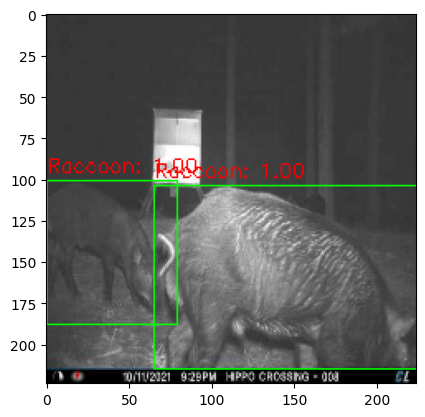

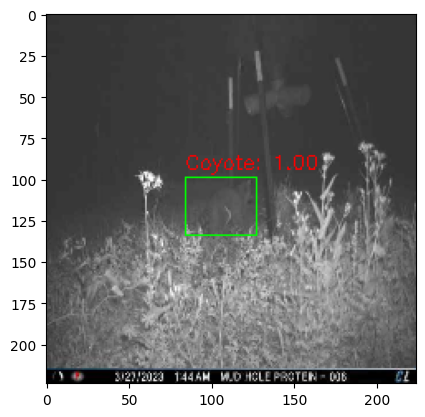

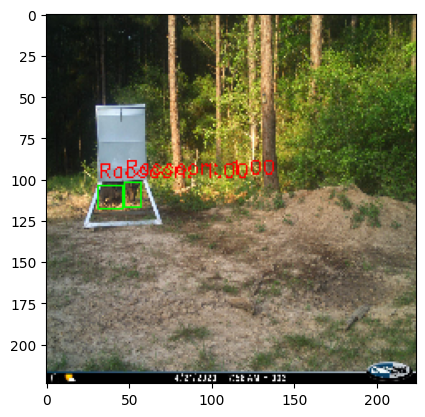

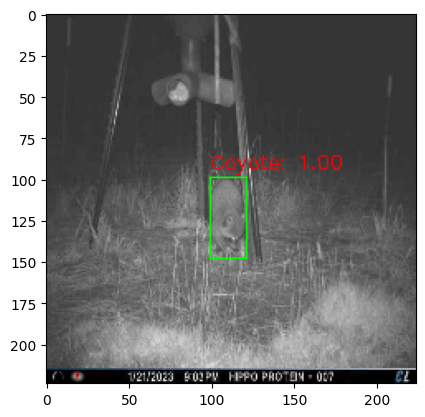

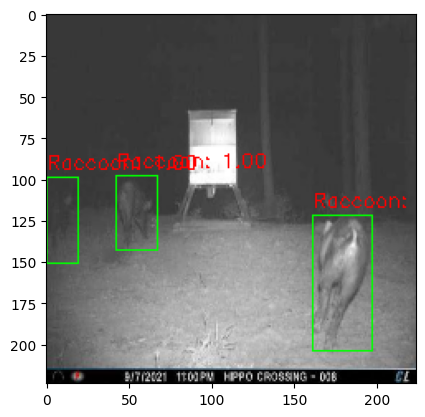

In [6]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Mapping from class index to class name
class_index_to_name = {0:'Coyote' , 1:'Deer' , 2: 'Hog', 3:'Rabbit' , 4: 'Raccoon'}

# Function to visualize images with bounding boxes
def visualize_images_with_boxes(dataset, num_images=5):
    # Select a few images from the dataset
    sample_dataset = dataset.take(num_images)

    for data in sample_dataset:
        image = data[0]['mobilenetv2_1.00_224_input'].numpy()
        boxes = data[1]['reshape_bbox'].numpy()
        classification = data[1]['classification'].numpy()

        # Convert image to uint8 and BGR format
        image = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

        # Plot bounding boxes using OpenCV
        for i, box in enumerate(boxes):
            xmin, ymin, xmax, ymax = box
            xmin = xmin * 224
            ymin = ymin * 224
            xmax = xmax * 224
            ymax = ymax * 224

            # Draw bounding box
            cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 1)

            # Draw class name and probability
            class_index = np.argmax(classification[i])
            class_name = class_index_to_name.get(class_index, "Unknown")
            confidence = classification[i, class_index]

            text = f"{class_name}: {confidence:.2f}"
            cv2.putText(image, text, (int(xmin), int(ymin) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

        # Display the image with bounding boxes
        plt.imshow(image)
        plt.show()

# Call the function to visualize 5 images from the dataset
visualize_images_with_boxes(valid_ds, num_images=5)


In [ ]:
print(class_index_to_name.keys())


dict_keys([0, 1, 2, 3, 4])


In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers

# using MobileNet as backbone for feature extraction
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freezing its layers
base_model.trainable = False

# Now designing our custom architecture
model = models.Sequential()

# Adding base model
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())

# Adding dense layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

# Two separate parallel branches for classification scores and bounding box predictions

# Classification branch
num_classes = 6  # Adjust based on the number of classes in your dataset
classification_branch = layers.Dense(5 * num_classes, activation='softmax', name='classification1')(model.layers[-1].output)
classification_reshaped = layers.Reshape((5, num_classes), name='classification')(classification_branch)

# Regression Branch for bounding box generation
bbox_branch = layers.Dense(5 * 4, activation='sigmoid', name='bounding_box')(model.layers[-1].output)
bbox_reshaped = layers.Reshape((5, 4), name='reshape_bbox')(bbox_branch)

# Model with both branches
model = models.Model(inputs=model.input, outputs=[classification_reshaped, bbox_reshaped])

# Print model summary
model.summary()




9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mobilenetv2_1.00_224_input  [(None, 224, 224, 3)]        0         []                            
  (InputLayer)                                                                                    
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['mobilenetv2_1.00_224_input[0
 tional)                                                            ][0]']                        
                                                                                                  
 global_average_pooling2d (  (None, 1280)                 0         ['mobilenetv2_1.00_224[0][0]']
 GlobalAveragePooling2D)       

In [8]:
# Compile the model with categorical_crossentropy and mean squared error as the loss functions for classification and regression branches, respectively.
model.compile(optimizer='adam',
              loss={'classification': 'categorical_crossentropy', 'reshape_bbox': 'mse'},
              metrics={'classification': 'accuracy', 'reshape_bbox': 'mae'})

In [9]:
# Assuming train_ds is your existing dataset
batch_size = 32

# Batch the dataset
train_ds = train_ds.batch(batch_size)
valid_ds = valid_ds.batch(batch_size)

# Print the number of batches in the dataset
print(len(train_ds))
print(len(valid_ds))


31
15


In [10]:
history = model.fit(train_ds, epochs=250, validation_data=valid_ds)

# Save the model for future use
model.save('MobileNet_Backbone_object_detection_model.h5')


Epoch 1/250
31/31 [==============================] - 17s 220ms/step - loss: 0.9396 - classification_loss: 0.7633 - reshape_bbox_loss: 0.1763 - classification_accuracy: 0.7767 - reshape_bbox_mae: 0.3147 - val_loss: 0.6615 - val_classification_loss: 0.5998 - val_reshape_bbox_loss: 0.0618 - val_classification_accuracy: 0.8102 - val_reshape_bbox_mae: 0.1890
Epoch 2/250
31/31 [==============================] - 3s 101ms/step - loss: 0.5403 - classification_loss: 0.4710 - reshape_bbox_loss: 0.0693 - classification_accuracy: 0.8584 - reshape_bbox_mae: 0.1794 - val_loss: 0.5910 - val_classification_loss: 0.5504 - val_reshape_bbox_loss: 0.0407 - val_classification_accuracy: 0.8249 - val_reshape_bbox_mae: 0.1268
Epoch 3/250
31/31 [==============================] - 3s 84ms/step - loss: 0.4219 - classification_loss: 0.3741 - reshape_bbox_loss: 0.0478 - classification_accuracy: 0.8803 - reshape_bbox_mae: 0.1377 - val_loss: 0.5777 - val_classification_loss: 0.5414 - val_reshape_bbox_loss: 0.0363 - va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


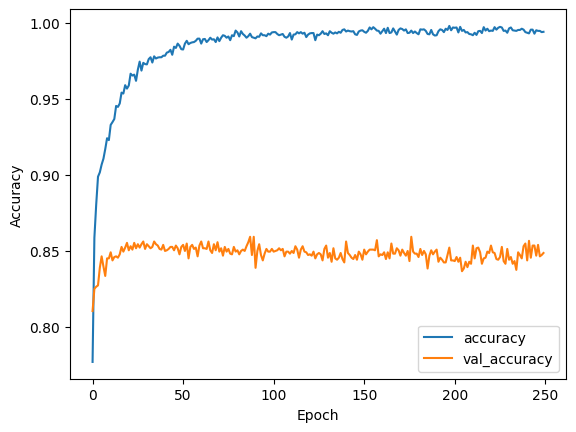

In [11]:
plt.plot(history.history['classification_accuracy'], label='accuracy')
plt.plot(history.history['val_classification_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

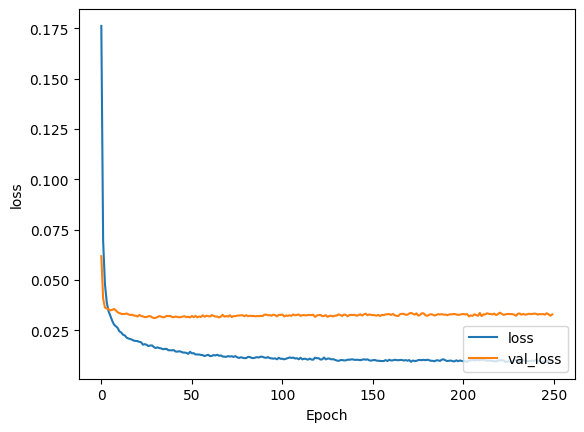

In [12]:
plt.plot(history.history['reshape_bbox_loss'], label='loss')
plt.plot(history.history['val_reshape_bbox_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [13]:
# Make predictions using the model
predictions = model.predict(valid_ds)

# Classification metrics
classification_predictions = predictions[0].reshape(-1, 5)
classification_targets = np.concatenate([y['classification'] for _, y in valid_ds], axis=0).reshape(-1, 5)
classification_targets = np.argmax(classification_targets, axis=-1)  # Convert one-hot encoding to class indices

print("Performance Metrics:")
print(classification_report(classification_targets, np.argmax(classification_predictions, axis=-1), zero_division=1))

# Bounding box metrics (IoU)
iou_predictions = predictions[1].reshape(-1, 4)
iou_targets = np.concatenate([y['reshape_bbox'] for _, y in valid_ds], axis=0).reshape(-1, 4)

# Compute IoU for each prediction
def calculate_iou(box1, box2):
    x1, y1, width1, height1 = box1
    x2, y2, width2, height2 = box2

    intersection_x = max(x1, x2)
    intersection_y = max(y1, y2)
    intersection_w = max(0, min(x1 + width1, x2 + width2) - intersection_x)
    intersection_h = max(0, min(y1 + height1, y2 + height2) - intersection_y)

    intersection_area = intersection_w * intersection_h
    union_area = (width1 * height1) + (width2 * height2) - intersection_area

    iou = intersection_area / union_area
    return iou

iou_scores = [calculate_iou(pred_box, target_box) for pred_box, target_box in zip(iou_predictions, iou_targets)]
average_iou = np.mean(iou_scores)

print(f"\nAverage IoU: {average_iou}")


15/15 [==============================] - 2s 51ms/step
Performance Metrics:
              precision    recall  f1-score   support

           0       0.86      0.49      0.63      1147
           1       0.04      0.16      0.07        50
           2       0.59      0.82      0.69       512
           3       0.67      0.88      0.76       446
           4       0.85      0.91      0.88       545

    accuracy                           0.70      2700
   macro avg       0.61      0.65      0.61      2700
weighted avg       0.76      0.70      0.70      2700


Average IoU: 0.07575113260529409


Error processing image 16_jpg.rf.4840471cdd5443eaf567712231010413.xml: cannot identify image file <_io.BytesIO object at 0x7d53c8f495d0>
Error processing image I__00924_JPG_jpg.rf.367829aaa0dc3bfe5c55479311101326.xml: cannot identify image file <_io.BytesIO object at 0x7d53c97a5030>
1/1 [==============================] - 1s 760ms/step


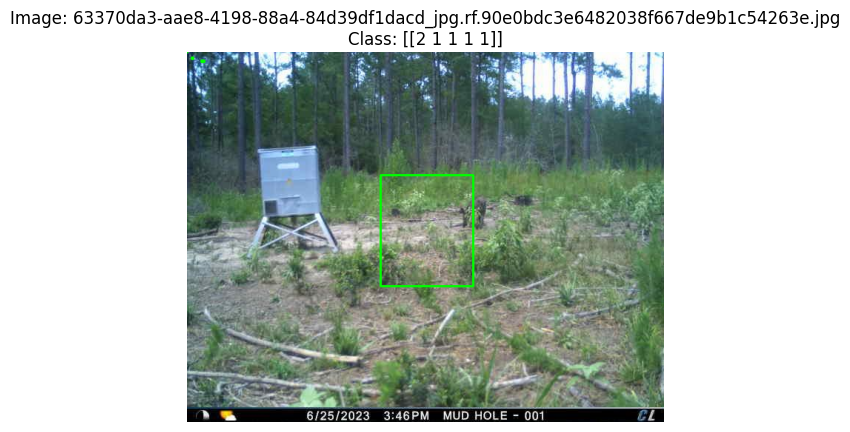

Error processing image 50cbde96-c77e-4ad2-9baf-9900ad721ca0_jpg.rf.e47332411c7520d2f6f7d8a02e3303e1.xml: cannot identify image file <_io.BytesIO object at 0x7d53bf7b8ae0>
Error processing image 54ccaf8f-bf72-4d3c-9577-aba7184123a2_jpg.rf.f5a483f8165108fe1505558ad9919bc0.xml: cannot identify image file <_io.BytesIO object at 0x7d53bf7b8ae0>
Error processing image coyote116_jpg.rf.ecd6abc79f873020be4d80fd904c2bea.xml: cannot identify image file <_io.BytesIO object at 0x7d53bf682390>
1/1 [==============================] - 0s 28ms/step


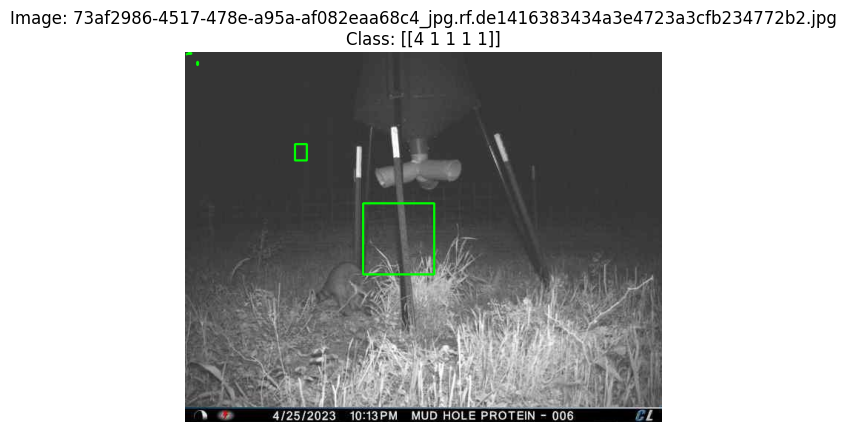

Error processing image 1be51ded-922b-48c8-b83d-aea824b3f9b3_jpg.rf.f7cfb4bf1bb9e527c4d2150e01d8c7a3.xml: cannot identify image file <_io.BytesIO object at 0x7d53bf65be70>
Error processing image I__00035-1_JPG_jpg.rf.620ccf575069f4e6ec449921f6b94414.xml: cannot identify image file <_io.BytesIO object at 0x7d53bf65b5b0>
Error processing image 13ab6496-c262-4d84-9c47-4970cf0d7b7a_jpg.rf.ea9f86f18ad05776c502fc228d4f2765.xml: cannot identify image file <_io.BytesIO object at 0x7d53bf6970b0>


In [16]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Load the saved model
model_path = 'MobileNet_Backbone_object_detection_model.h5'
model = load_model(model_path)

# Path to the test images
test_images_path = '/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/test'

# Randomly select 10 images
selected_images = np.random.choice(os.listdir(test_images_path), size=10, replace=False)

# Iterate over selected images
for image_name in selected_images:
    try:
        # Load and preprocess the image
        img_path = os.path.join(test_images_path, image_name)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make predictions
        predictions = model.predict(img_array)

        # Extract classification and bounding box predictions
        classification_pred, bbox_pred = predictions

        # Post-process classification predictions
        classification_pred = np.argmax(classification_pred, axis=-1)

        # Post-process bounding box predictions
        # You might need to adjust the post-processing based on your specific implementation
        # This is a simple example assuming 5 bounding boxes
        bbox_pred = np.reshape(bbox_pred, (5, 4))

        # Visualize the results
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Draw bounding boxes on the image
        for bbox in bbox_pred:
            xmin, ymin, xmax, ymax = bbox
            xmin, ymin, xmax, ymax = int(xmin * img.shape[1]), int(ymin * img.shape[0]), int(xmax * img.shape[1]), int(ymax * img.shape[0])
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Display the image with predictions
        plt.imshow(img)
        plt.title(f"Image: {image_name}\nClass: {classification_pred}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error processing image {image_name}: {str(e)}")


1/1 [==============================] - 2s 2s/step


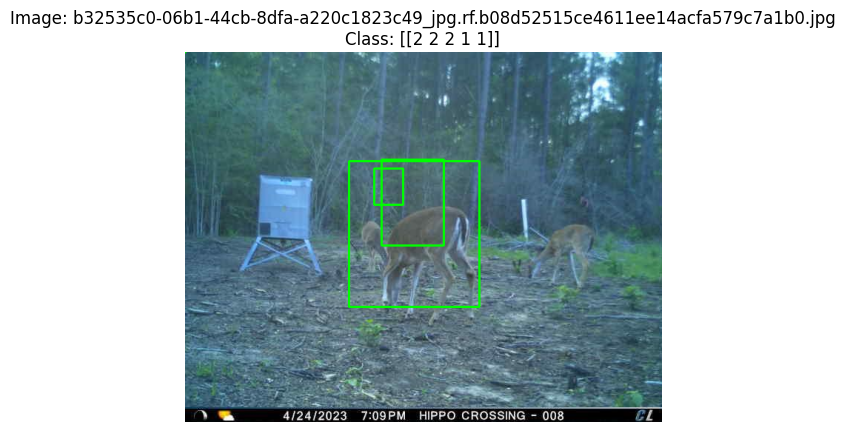

1/1 [==============================] - 0s 26ms/step


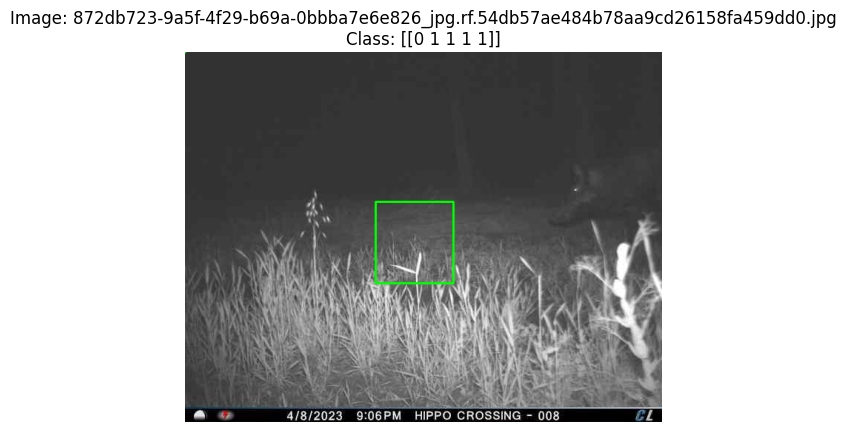

1/1 [==============================] - 0s 24ms/step


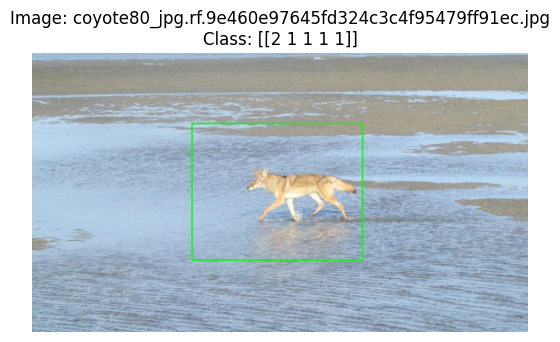

Error processing image 1a9409af-7bd7-45d1-bcea-6a363586d585_jpg.rf.0a6a2300f4ac8a57c7b3dc2ac8538b7f.xml: cannot identify image file <_io.BytesIO object at 0x7d53c378b330>
1/1 [==============================] - 0s 30ms/step


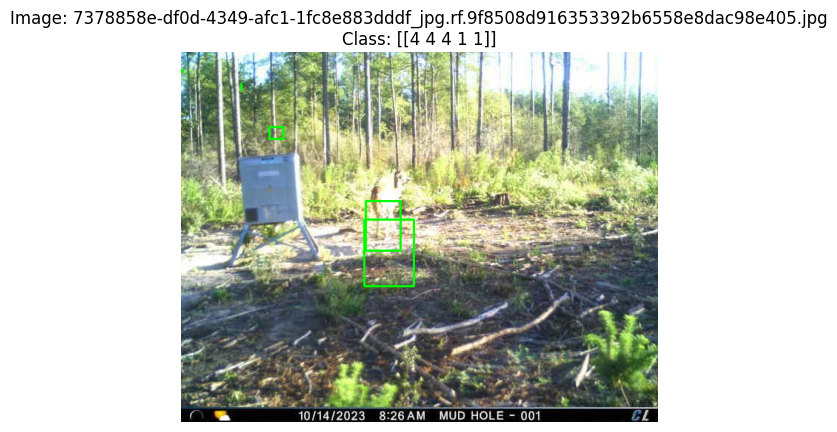

Error processing image b7bb96c7-5cfa-43a7-9c45-1153c6fad774_jpg.rf.bf7d63a3b0fdd23b3f38309b4a1a9886.xml: cannot identify image file <_io.BytesIO object at 0x7d53c3788090>
1/1 [==============================] - 0s 33ms/step


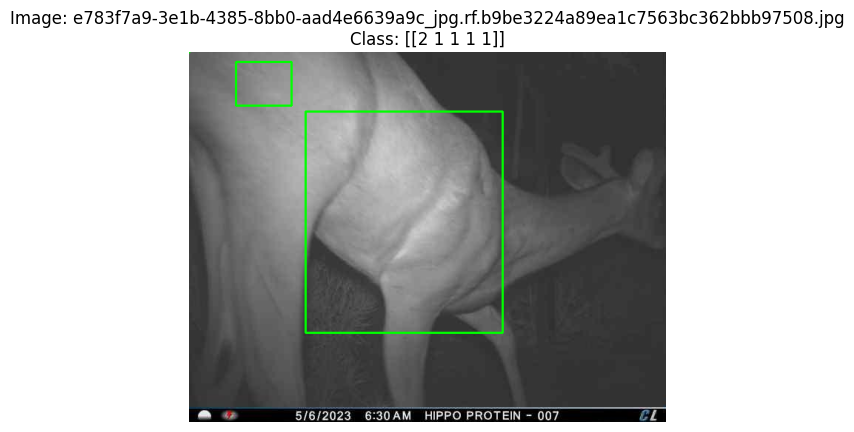

Error processing image f7e09177-94d5-4913-87e3-fa13f399bbb7_jpg.rf.1b51866239bc7ce83ed88632be155822.xml: cannot identify image file <_io.BytesIO object at 0x7d53c39124d0>
Error processing image 2948b03d-81c4-4e46-aa1a-0ea662854d38_jpg.rf.67056ae07abdba586bfed41c7571669b.xml: cannot identify image file <_io.BytesIO object at 0x7d53c393ddf0>
1/1 [==============================] - 0s 21ms/step


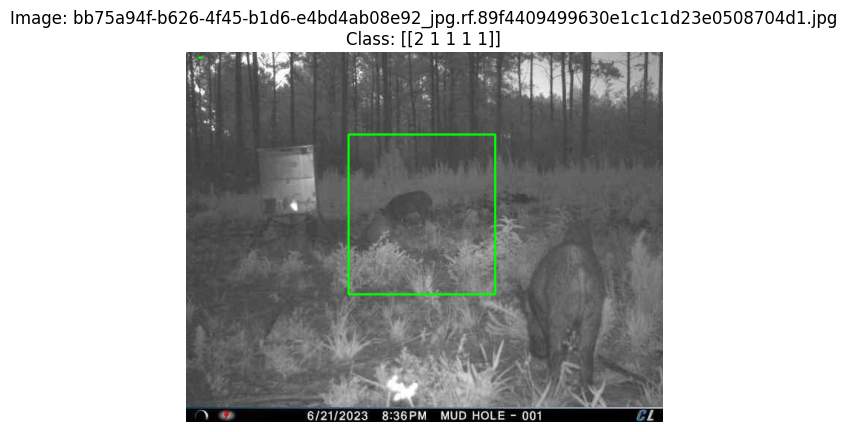

In [17]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Load the saved model
model_path = 'MobileNet_Backbone_object_detection_model.h5'
model = load_model(model_path)

# Path to the test images
test_images_path = '/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/test'

# Randomly select 10 images
selected_images = np.random.choice(os.listdir(test_images_path), size=10, replace=False)

# Iterate over selected images
for image_name in selected_images:
    try:
        # Load and preprocess the image
        img_path = os.path.join(test_images_path, image_name)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make predictions
        predictions = model.predict(img_array)

        # Extract classification and bounding box predictions
        classification_pred, bbox_pred = predictions

        # Post-process classification predictions
        classification_pred = np.argmax(classification_pred, axis=-1)

        # Post-process bounding box predictions
        # You might need to adjust the post-processing based on your specific implementation
        # This is a simple example assuming 5 bounding boxes
        bbox_pred = np.reshape(bbox_pred, (5, 4))

        # Visualize the results
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Draw bounding boxes on the image
        for bbox in bbox_pred:
            xmin, ymin, xmax, ymax = bbox
            xmin, ymin, xmax, ymax = int(xmin * img.shape[1]), int(ymin * img.shape[0]), int(xmax * img.shape[1]), int(ymax * img.shape[0])
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Display the image with predictions
        plt.imshow(img)
        plt.title(f"Image: {image_name}\nClass: {classification_pred}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error processing image {image_name}: {str(e)}")


1/1 [==============================] - 1s 780ms/step


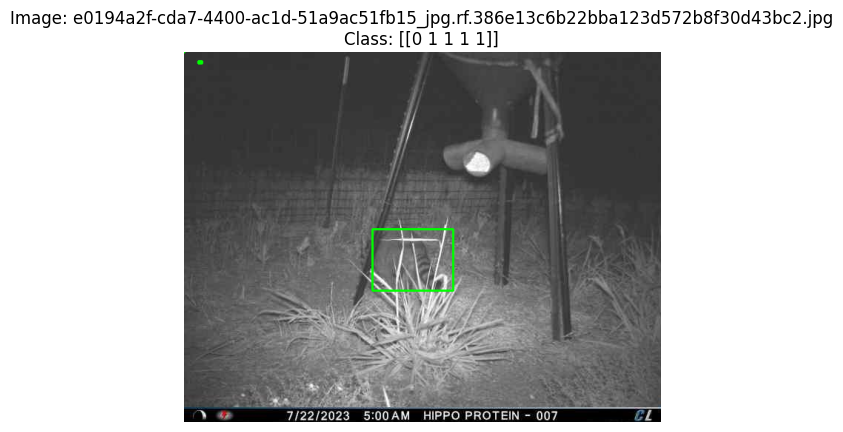

1/1 [==============================] - 0s 29ms/step


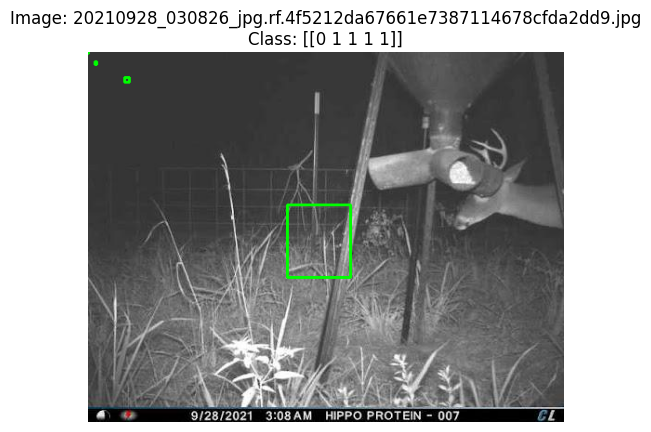

1/1 [==============================] - 0s 21ms/step


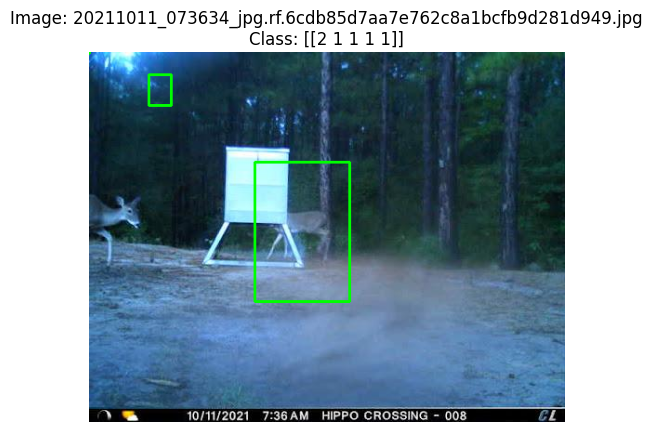

Error processing image 20210927_031320_jpg.rf.66c7121d75a6f5566bea7fd7ee8b3010.xml: cannot identify image file <_io.BytesIO object at 0x7d53c3ca0a40>
1/1 [==============================] - 0s 21ms/step


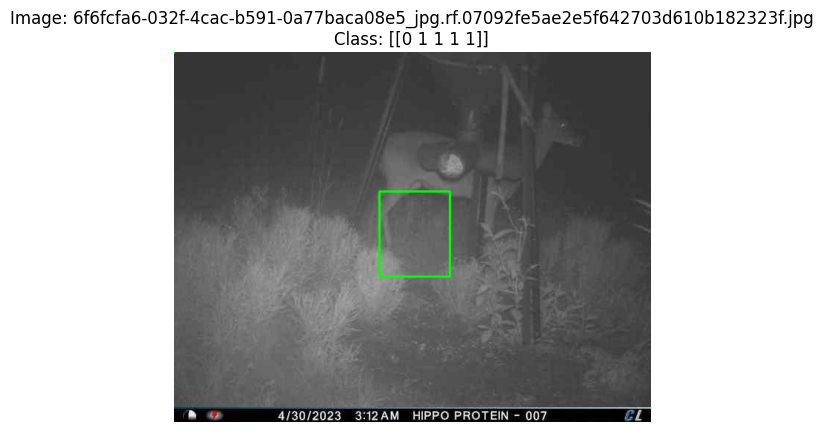

1/1 [==============================] - 0s 21ms/step


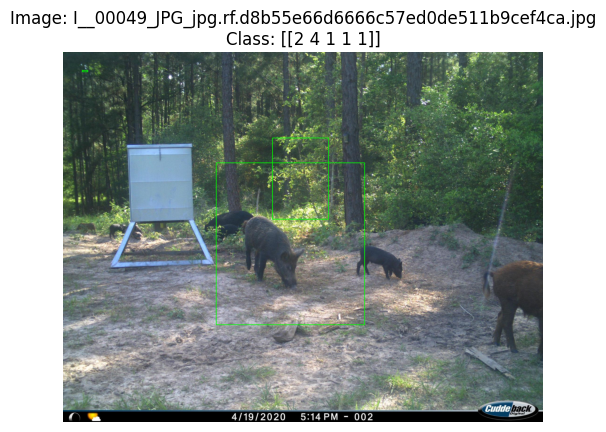

1/1 [==============================] - 0s 33ms/step


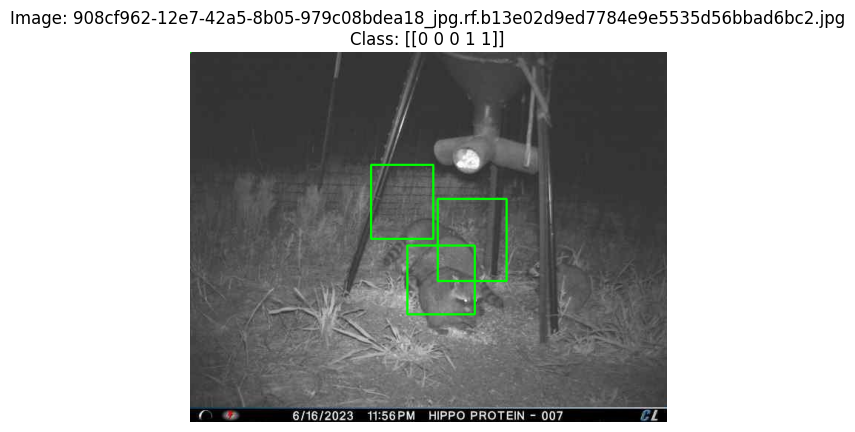

1/1 [==============================] - 0s 34ms/step


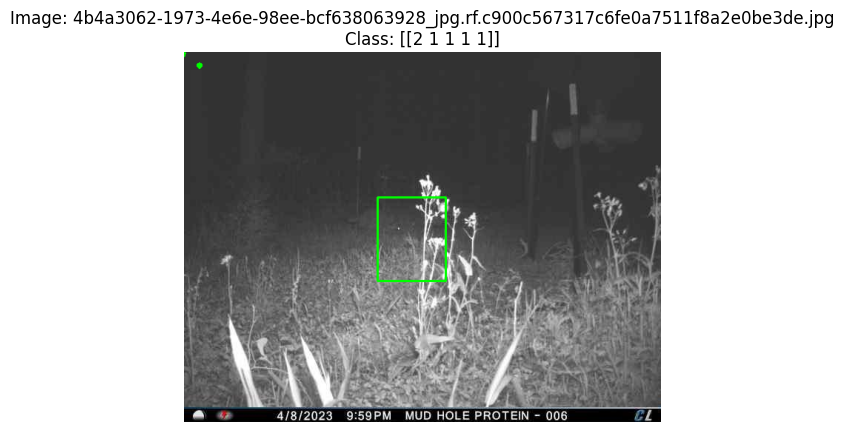

1/1 [==============================] - 0s 37ms/step


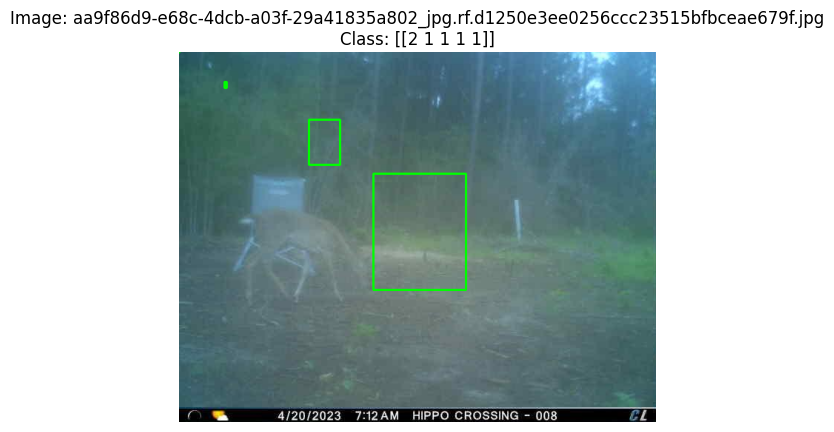

1/1 [==============================] - 0s 35ms/step


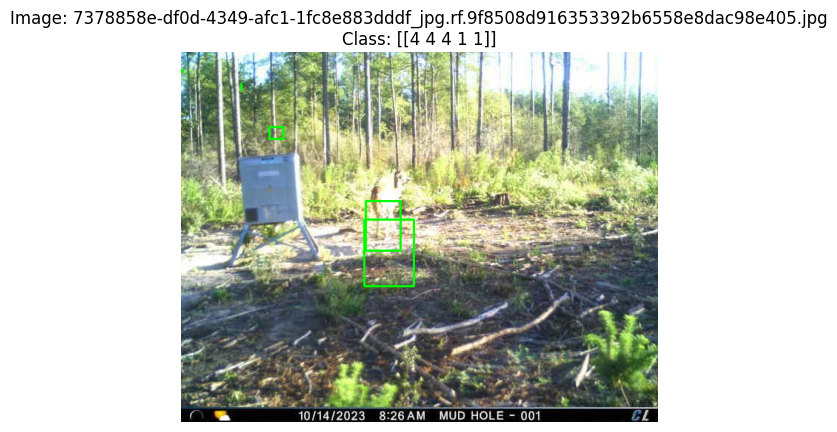

In [18]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Load the saved model
model_path = 'MobileNet_Backbone_object_detection_model.h5'
model = load_model(model_path)

# Path to the test images
test_images_path = '/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/test'

# Randomly select 10 images
selected_images = np.random.choice(os.listdir(test_images_path), size=10, replace=False)

# Iterate over selected images
for image_name in selected_images:
    try:
        # Load and preprocess the image
        img_path = os.path.join(test_images_path, image_name)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make predictions
        predictions = model.predict(img_array)

        # Extract classification and bounding box predictions
        classification_pred, bbox_pred = predictions

        # Post-process classification predictions
        classification_pred = np.argmax(classification_pred, axis=-1)

        # Post-process bounding box predictions
        # You might need to adjust the post-processing based on your specific implementation
        # This is a simple example assuming 5 bounding boxes
        bbox_pred = np.reshape(bbox_pred, (5, 4))

        # Visualize the results
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Draw bounding boxes on the image
        for bbox in bbox_pred:
            xmin, ymin, xmax, ymax = bbox
            xmin, ymin, xmax, ymax = int(xmin * img.shape[1]), int(ymin * img.shape[0]), int(xmax * img.shape[1]), int(ymax * img.shape[0])
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Display the image with predictions
        plt.imshow(img)
        plt.title(f"Image: {image_name}\nClass: {classification_pred}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error processing image {image_name}: {str(e)}")


Error processing image coyote192_jpg.rf.4c1edc2143f641ef0f237bdb699a9e1b.xml: cannot identify image file <_io.BytesIO object at 0x7d53c8f4aca0>
Error processing image 260dcbbe-fd83-4025-8519-2192fe51abfd_jpg.rf.8b642fd3bf5c7cc5e286059f483ca5aa.xml: cannot identify image file <_io.BytesIO object at 0x7d53c8f4aca0>
Error processing image 357c982a-a6c7-4b12-9218-c9d59ab697cd_jpg.rf.19013127534bf25c5b8cfd62a601826e.xml: cannot identify image file <_io.BytesIO object at 0x7d53c951b920>
Error processing image I__00083-1_JPG_jpg.rf.2231530624da41eae2b88b9f1c2b97e3.xml: cannot identify image file <_io.BytesIO object at 0x7d53c9520ae0>
Error processing image b6e363bd-87e9-47b8-a711-6981e615a91a_jpg.rf.47470b90b0984d5a6042aebeb1d3442c.xml: cannot identify image file <_io.BytesIO object at 0x7d53c37fc090>
1/1 [==============================] - 2s 2s/step


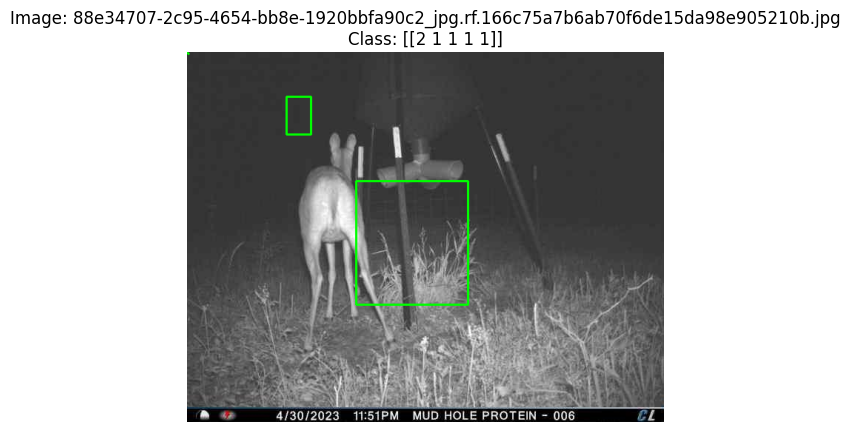

1/1 [==============================] - 0s 81ms/step


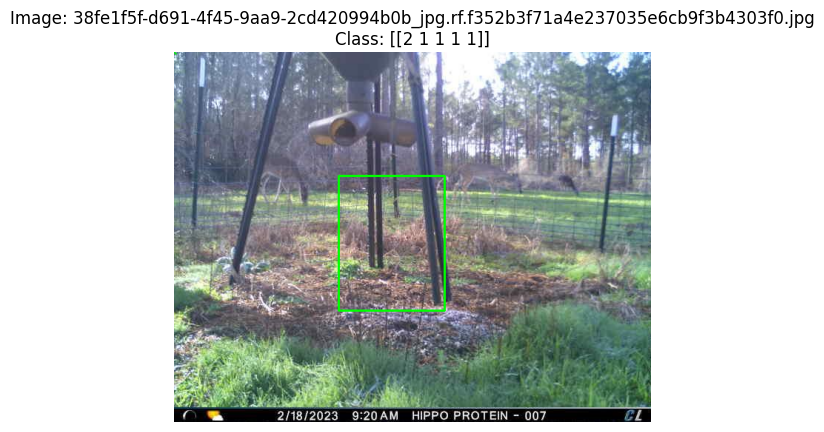

Error processing image MDRICKAMER_T_00008_JPG.rf.16525eb642e25ef67ae9bf6218245662.xml: cannot identify image file <_io.BytesIO object at 0x7d53c0a4b1a0>
1/1 [==============================] - 0s 87ms/step


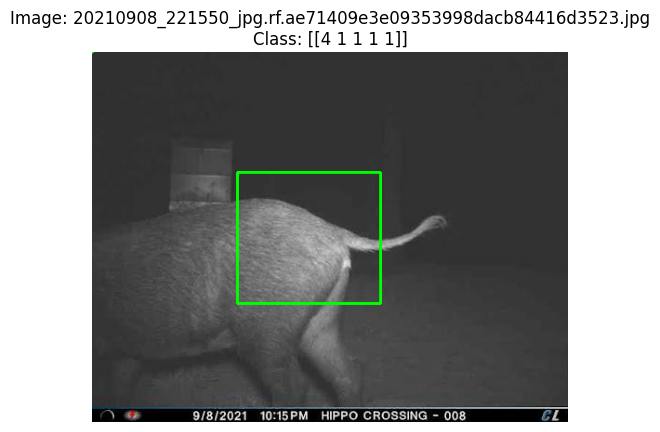

Error processing image f2584996-136d-41b0-b41f-91841eeedbb1_jpg.rf.f031376d988efee940c64996b8a30116.xml: cannot identify image file <_io.BytesIO object at 0x7d53c8a1d760>


In [19]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Load the saved model
model_path = 'MobileNet_Backbone_object_detection_model.h5'
model = load_model(model_path)

# Path to the test images
test_images_path = '/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/test'

# Randomly select 10 images
selected_images = np.random.choice(os.listdir(test_images_path), size=10, replace=False)

# Iterate over selected images
for image_name in selected_images:
    try:
        # Load and preprocess the image
        img_path = os.path.join(test_images_path, image_name)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make predictions
        predictions = model.predict(img_array)

        # Extract classification and bounding box predictions
        classification_pred, bbox_pred = predictions

        # Post-process classification predictions
        classification_pred = np.argmax(classification_pred, axis=-1)

        # Post-process bounding box predictions
        # You might need to adjust the post-processing based on your specific implementation
        # This is a simple example assuming 5 bounding boxes
        bbox_pred = np.reshape(bbox_pred, (5, 4))

        # Visualize the results
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Draw bounding boxes on the image
        for bbox in bbox_pred:
            xmin, ymin, xmax, ymax = bbox
            xmin, ymin, xmax, ymax = int(xmin * img.shape[1]), int(ymin * img.shape[0]), int(xmax * img.shape[1]), int(ymax * img.shape[0])
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Display the image with predictions
        plt.imshow(img)
        plt.title(f"Image: {image_name}\nClass: {classification_pred}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error processing image {image_name}: {str(e)}")


Error processing image 50cbde96-c77e-4ad2-9baf-9900ad721ca0_jpg.rf.e47332411c7520d2f6f7d8a02e3303e1.xml: cannot identify image file <_io.BytesIO object at 0x7d53c3ad76f0>
Error processing image 20210908_221550_jpg.rf.ae71409e3e09353998dacb84416d3523.xml: cannot identify image file <_io.BytesIO object at 0x7d53bf6803b0>
1/1 [==============================] - 2s 2s/step


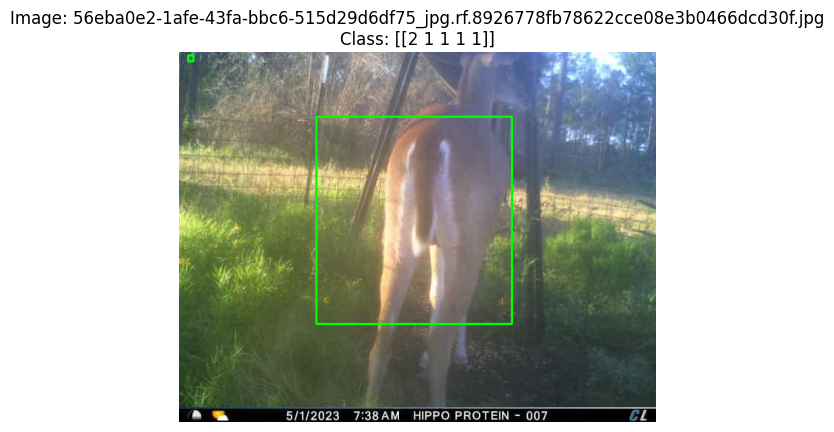

Error processing image Deer-Hog-HIPPO_PROTEIN-20220809_053304_JPG.rf.cb3b93f40b7bcb6ddcda32ba33936228.xml: cannot identify image file <_io.BytesIO object at 0x7d53c89da520>
1/1 [==============================] - 0s 42ms/step


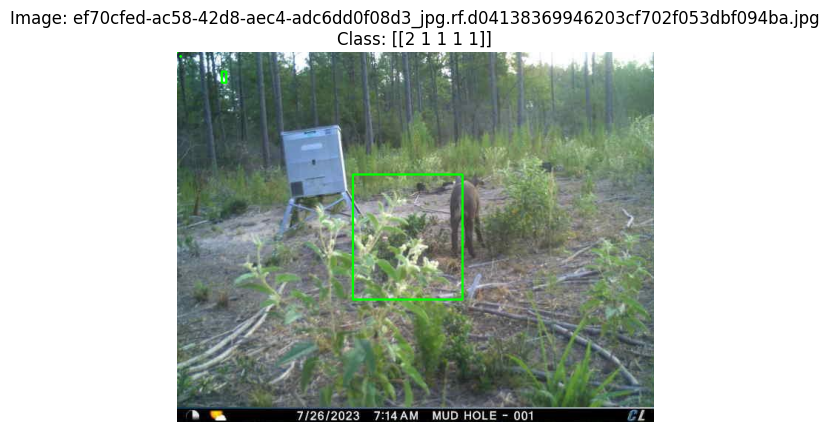

1/1 [==============================] - 0s 27ms/step


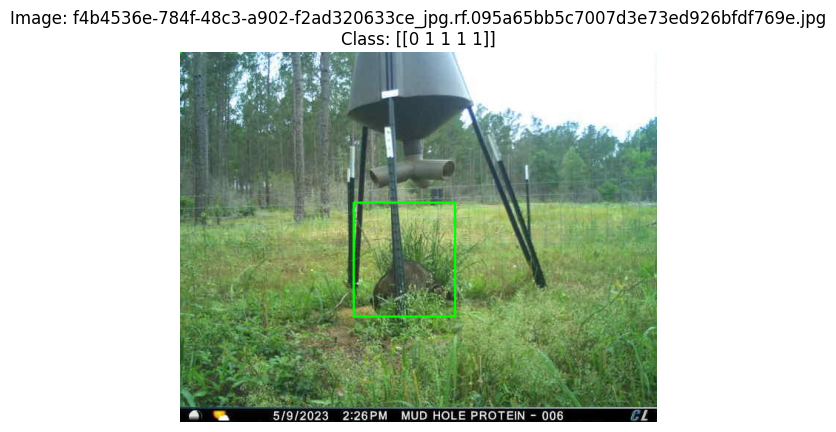

Error processing image 20210922_212314_jpg.rf.06dc91cb6fad1cd3adde5c0e4e5dc17d.xml: cannot identify image file <_io.BytesIO object at 0x7d53bf83d990>
Error processing image Deer-DRIVEWAY-20220808_214130_JPG.rf.b92246f976c979e6ec52c2e8af036e6e.xml: cannot identify image file <_io.BytesIO object at 0x7d53bf83d2b0>
1/1 [==============================] - 0s 34ms/step


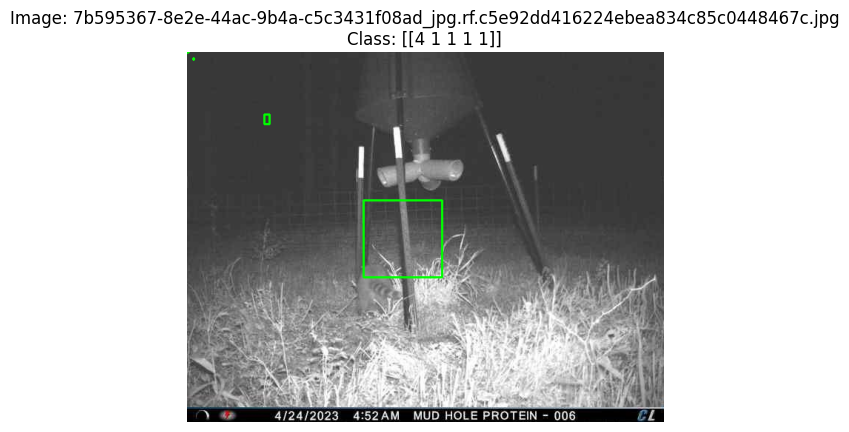

1/1 [==============================] - 0s 29ms/step


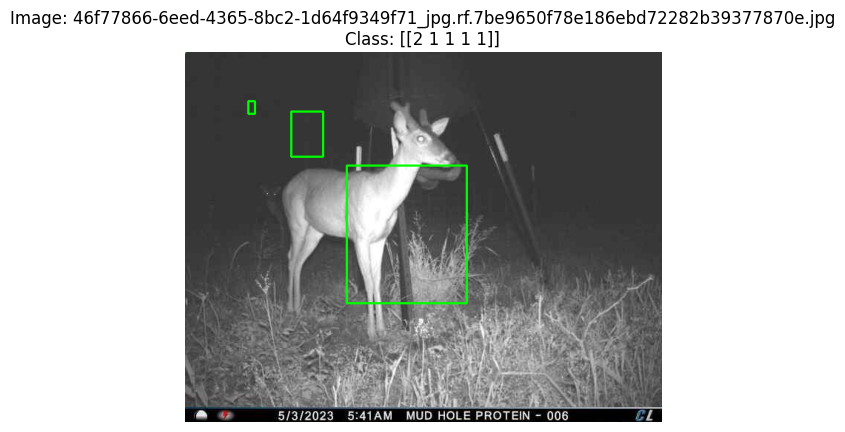

In [20]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Load the saved model
model_path = 'MobileNet_Backbone_object_detection_model.h5'
model = load_model(model_path)

# Path to the test images
test_images_path = '/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/test'

# Randomly select 10 images
selected_images = np.random.choice(os.listdir(test_images_path), size=10, replace=False)

# Iterate over selected images
for image_name in selected_images:
    try:
        # Load and preprocess the image
        img_path = os.path.join(test_images_path, image_name)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make predictions
        predictions = model.predict(img_array)

        # Extract classification and bounding box predictions
        classification_pred, bbox_pred = predictions

        # Post-process classification predictions
        classification_pred = np.argmax(classification_pred, axis=-1)

        # Post-process bounding box predictions
        # You might need to adjust the post-processing based on your specific implementation
        # This is a simple example assuming 5 bounding boxes
        bbox_pred = np.reshape(bbox_pred, (5, 4))

        # Visualize the results
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Draw bounding boxes on the image
        for bbox in bbox_pred:
            xmin, ymin, xmax, ymax = bbox
            xmin, ymin, xmax, ymax = int(xmin * img.shape[1]), int(ymin * img.shape[0]), int(xmax * img.shape[1]), int(ymax * img.shape[0])
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Display the image with predictions
        plt.imshow(img)
        plt.title(f"Image: {image_name}\nClass: {classification_pred}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error processing image {image_name}: {str(e)}")
